# Spatiotemporal mortality modelling using Gaussian process regression
Aim: model the death rate in each spatial unit (LSOA in London) over the years 2002-2017 for 19 age groups (0, 1-4, 5-9, 10-14, ..., 80-94, 85+). (Note this is simulated data due to the sensitivity of health records, and this dataset only covers 2004-2017.)

In [1]:
import math
import torch
import pyro
import tqdm
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

## Load the data
Load the mortality dataset and the centroids of each LSOA.

There is also the option to load a subset of the data covering only Hammersmith and Fulham.

In [58]:
data_path   = "/rds/general/user/tar15/home/mortality-statsmodel/Data/"

hammersmith = False
if hammersmith:
    mortality = pd.read_csv(data_path + "mortsim_hf" + ".csv")
    print("LOADED HAMMERSMITH DATA")
else:
    mortality = pd.read_csv(data_path + "mortsim" + ".csv")
    print("LOADED LONDON DATA")
mortality = mortality[[
    "LAD2011", "MSOA2011", "LSOA2011", "YEAR", "age_group", "sex", "deaths", "population", "IMD.score"
]]

LOADED LONDON DATA


In [59]:
mortality

,LAD2011,MSOA2011,LSOA2011,YEAR,age_group,sex,deaths,population,IMD.score
0,E09000001,E02000001,E01000001,2004,0,1,0,3,6.520
1,E09000001,E02000001,E01000001,2004,1_4,1,0,17,6.520
2,E09000001,E02000001,E01000001,2004,5_9,1,0,16,6.520
3,E09000001,E02000001,E01000001,2004,10_14,1,0,8,6.520
4,E09000001,E02000001,E01000001,2004,15_19,1,0,10,6.520
...,...,...,...,...,...,...,...,...,...
2572215,E09000011,E02006931,E01033746,2017,65_69,2,2,36,22.292
2572216,E09000011,E02006931,E01033746,2017,70_74,2,2,37,22.292
2572217,E09000011,E02006931,E01033746,2017,75_79,2,4,33,22.292
2572218,E09000011,E02006931,E01033746,2017,80_84,2,1,33,22.292


In [60]:
centroids = pd.read_csv(data_path + "ldn_centroids" + ".csv")
centroids = centroids[["LSOA2011", "name", "coords.x1", "coords.x2"]]

In [61]:
centroids

,LSOA2011,name,coords.x1,coords.x2
0,E01000001,City of London 001A,532150.839566,181617.460916
1,E01000002,City of London 001B,532443.368721,181643.602822
2,E01000003,City of London 001C,532205.546324,182030.047059
3,E01000005,City of London 001E,533620.049037,181152.840191
4,E01000006,Barking and Dagenham 016A,544933.448417,184296.481282
...,...,...,...,...
4830,E01033742,Greenwich 007F,544442.251463,179692.607185
4831,E01033743,Greenwich 002H,545762.511775,180757.894534
4832,E01033744,Greenwich 007G,544539.564412,179303.703292
4833,E01033745,Greenwich 002I,546168.615531,180007.327034


The centres of the age groups have been calculated as the life expectancy from mean death rates of each age group.

In [62]:
age_centres = [
    0.05649526, 2.63893940, 7.50000000, 12.50000000, 17.65215935, 22.52097029, 27.51978992, 32.55024244,
    37.69773327, 42.76370351, 47.71774779, 52.77291601, 57.70702200, 62.63892450, 67.63190211, 72.41333635,
    77.36997872, 82.26084695, 89.96681347 
]

age_dict = dict(zip(mortality["age_group"].unique(), age_centres))

In [63]:
mortality = pd.merge(mortality, centroids)
# mortality = pd.merge(mortality, age_df)
mortality["age"] = mortality["age_group"].map(age_dict)
mortality

,LAD2011,MSOA2011,LSOA2011,YEAR,age_group,sex,deaths,population,IMD.score,name,coords.x1,coords.x2,age
0,E09000001,E02000001,E01000001,2004,0,1,0,3,6.520,City of London 001A,532150.839566,181617.460916,0.056495
1,E09000001,E02000001,E01000001,2004,1_4,1,0,17,6.520,City of London 001A,532150.839566,181617.460916,2.638939
2,E09000001,E02000001,E01000001,2004,5_9,1,0,16,6.520,City of London 001A,532150.839566,181617.460916,7.500000
3,E09000001,E02000001,E01000001,2004,10_14,1,0,8,6.520,City of London 001A,532150.839566,181617.460916,12.500000
4,E09000001,E02000001,E01000001,2004,15_19,1,0,10,6.520,City of London 001A,532150.839566,181617.460916,17.652159
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2572215,E09000011,E02006931,E01033746,2017,65_69,2,2,36,22.292,Greenwich 038E,538053.851750,177045.460068,67.631902
2572216,E09000011,E02006931,E01033746,2017,70_74,2,2,37,22.292,Greenwich 038E,538053.851750,177045.460068,72.413336
2572217,E09000011,E02006931,E01033746,2017,75_79,2,4,33,22.292,Greenwich 038E,538053.851750,177045.460068,77.369979
2572218,E09000011,E02006931,E01033746,2017,80_84,2,1,33,22.292,Greenwich 038E,538053.851750,177045.460068,82.260847


In [ ]:
mortality.to_csv("mortality.csv", index = False)

## Create training and test sets

Work on men only for now

In [8]:
mortality_m = mortality[mortality["sex"] == 1]

Test on all the data coordinates

In [9]:
test_x = mortality_m[["coords.x1", "coords.x2", "YEAR", "age"]]
test_x = torch.tensor(test_x.values)
test_x

tensor([[5.2376e+05, 1.7928e+05, 2.0040e+03, 5.6495e-02],
        [5.2376e+05, 1.7928e+05, 2.0040e+03, 2.6389e+00],
        [5.2376e+05, 1.7928e+05, 2.0040e+03, 7.5000e+00],
        ...,
        [5.2633e+05, 1.7617e+05, 2.0170e+03, 7.7370e+01],
        [5.2633e+05, 1.7617e+05, 2.0170e+03, 8.2261e+01],
        [5.2633e+05, 1.7617e+05, 2.0170e+03, 8.9967e+01]], dtype=torch.float64)

Only train on data with non-negative populations. Zero population strata provide no information and will not work with log link offset in the likelihood.

In [10]:
mortality_m = mortality_m[mortality_m["population"] != 0]
mortality_m["death rate"] = mortality_m["deaths"]/mortality_m["population"]
mortality_m

,LAD2011,MSOA2011,LSOA2011,YEAR,age_group,sex,deaths,population,IMD.score,name,coords.x1,coords.x2,age,death rate
0,E09000013,E02000381,E01001851,2004,0,1,0,19,16.280,Hammersmith and Fulham 010A,523756.537745,179279.977178,0.056495,0.000000
1,E09000013,E02000381,E01001851,2004,1_4,1,0,49,16.280,Hammersmith and Fulham 010A,523756.537745,179279.977178,2.638939,0.000000
2,E09000013,E02000381,E01001851,2004,5_9,1,0,38,16.280,Hammersmith and Fulham 010A,523756.537745,179279.977178,7.500000,0.000000
3,E09000013,E02000381,E01001851,2004,10_14,1,0,28,16.280,Hammersmith and Fulham 010A,523756.537745,179279.977178,12.500000,0.000000
4,E09000013,E02000381,E01001851,2004,15_19,1,0,51,16.280,Hammersmith and Fulham 010A,523756.537745,179279.977178,17.652159,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60092,E09000013,E02000394,E01032790,2017,65_69,1,0,13,21.194,Hammersmith and Fulham 023F,526330.848297,176173.601903,67.631902,0.000000
60093,E09000013,E02000394,E01032790,2017,70_74,1,3,24,21.194,Hammersmith and Fulham 023F,526330.848297,176173.601903,72.413336,0.125000
60094,E09000013,E02000394,E01032790,2017,75_79,1,0,12,21.194,Hammersmith and Fulham 023F,526330.848297,176173.601903,77.369979,0.000000
60095,E09000013,E02000394,E01032790,2017,80_84,1,3,18,21.194,Hammersmith and Fulham 023F,526330.848297,176173.601903,82.260847,0.166667


In [11]:
train_x = mortality_m[["coords.x1", "coords.x2", "YEAR", "age"]]
# rescale the columns because GP regression works better when the mean is around zero (standardise)
train_x = train_x.apply(lambda x: (x - x.mean()) / x.std())
train_x = torch.tensor(train_x.values)
train_x

tensor([[-0.0643,  0.5770, -1.6170, -1.5620],
        [-0.0643,  0.5770, -1.6170, -1.4673],
        [-0.0643,  0.5770, -1.6170, -1.2890],
        ...,
        [ 2.0518, -1.4541,  1.6098,  1.2735],
        [ 2.0518, -1.4541,  1.6098,  1.4529],
        [ 2.0518, -1.4541,  1.6098,  1.7355]], dtype=torch.float64)

In [12]:
train_y = mortality_m[["death rate"]]
train_y = torch.tensor(train_y.values)
train_y

tensor([[0.0000],
        [0.0000],
        [0.0000],
        ...,
        [0.0000],
        [0.1667],
        [0.0000]], dtype=torch.float64)

### Actually, for now, let's just focus on age vs death rate as it is a much smaller test dataset

In [17]:
mortality_m = mortality[mortality["sex"] == 1]
mortality_m = mortality_m.groupby(["age"])[["deaths", "population"]].sum().reset_index()
mortality_m["death rate"] = mortality_m["deaths"]/mortality_m["population"]
mortality_m

,age,deaths,population,death rate
0,0.056495,70,18002,0.003888
1,2.638939,10,62638,0.000160
2,7.500000,11,64941,0.000169
3,12.500000,12,53969,0.000222
4,17.652159,36,57225,0.000629
5,22.520970,68,104824,0.000649
6,27.519790,112,159261,0.000703
7,32.550242,119,155465,0.000765
8,37.697733,117,122318,0.000957
9,42.763704,177,94708,0.001869


In [48]:
train_x = mortality_m[["age"]]
# rescale the columns because GP regression works better when the mean is around zero (standardise)
train_x = train_x.apply(lambda x: (x - x.mean()) / x.std())
train_x = torch.tensor(train_x["age"].values)
train_x

tensor([-1.5219, -1.4300, -1.2571, -1.0792, -0.8959, -0.7227, -0.5449, -0.3659,
        -0.1828, -0.0026,  0.1737,  0.3535,  0.5291,  0.7045,  0.8821,  1.0522,
         1.2286,  1.4026,  1.6767], dtype=torch.float64)

In [49]:
train_y = mortality_m[["death rate"]]
train_y = torch.tensor(train_y["death rate"].values)
train_y

tensor([3.8885e-03, 1.5965e-04, 1.6938e-04, 2.2235e-04, 6.2910e-04, 6.4871e-04,
        7.0325e-04, 7.6545e-04, 9.5652e-04, 1.8689e-03, 3.0256e-03, 5.3471e-03,
        1.0660e-02, 1.7558e-02, 2.7393e-02, 4.4909e-02, 6.8142e-02, 1.3001e-01,
        1.7224e-01], dtype=torch.float64)

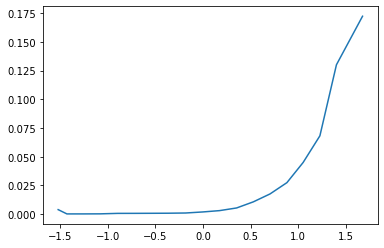

In [50]:
plt.plot(train_x.numpy(), train_y.numpy())

## 1. Simple GP regression
Let's ignore the Poisson/Negative Binonmial likelihood for now and just get a GP regression setup working.

In [51]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [52]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [53]:
# Find optimal model hyperparameters
# model.double()
model.train()
likelihood.train()

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

In [56]:
training_iter = 200

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/200 - Loss: -2.717   lengthscale: 1.075   noise: 0.000
Iter 2/200 - Loss: -2.669   lengthscale: 1.142   noise: 0.000
Iter 3/200 - Loss: -2.718   lengthscale: 1.092   noise: 0.000
Iter 4/200 - Loss: -2.711   lengthscale: 1.057   noise: 0.000
Iter 5/200 - Loss: -2.697   lengthscale: 1.063   noise: 0.000
Iter 6/200 - Loss: -2.705   lengthscale: 1.090   noise: 0.000
Iter 7/200 - Loss: -2.721   lengthscale: 1.127   noise: 0.000
Iter 8/200 - Loss: -2.729   lengthscale: 1.167   noise: 0.000
Iter 9/200 - Loss: -2.725   lengthscale: 1.199   noise: 0.000
Iter 10/200 - Loss: -2.719   lengthscale: 1.215   noise: 0.000
Iter 11/200 - Loss: -2.719   lengthscale: 1.215   noise: 0.000
Iter 12/200 - Loss: -2.725   lengthscale: 1.203   noise: 0.000
Iter 13/200 - Loss: -2.731   lengthscale: 1.185   noise: 0.000
Iter 14/200 - Loss: -2.733   lengthscale: 1.165   noise: 0.000
Iter 15/200 - Loss: -2.731   lengthscale: 1.148   noise: 0.000
Iter 16/200 - Loss: -2.729   lengthscale: 1.138   noise: 0.000
I

## 2. More complex likelihood
Use the Pyro integration to use a more complicated likelihood.